In [32]:
#%pip install moondream

In [33]:
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv 
import json
from transformers import AutoTokenizer
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

API_KEY = os.getenv("MOONDREAM_API_KEY")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")
FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

OUTPUT_MOONDREAM_CAPTIONS = PARENT + os.getenv("OUTPUT_MOONDREAM_CAPTIONS")
##

In [34]:
artpieces = pd.read_csv(DB_INPUT_ARTPIECES)
artpieces.head(1)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.84573


In [35]:
subjectmatter = pd.read_csv(DB_INPUT_SUBJECTMATTER)
subjectmatter.head(1)

,recordID,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
0,64,scène (homme ; femme ; enfant ; vêtement : hab...,scène biblique ([SO] : Nouveau Testament : Eva...,NaN,NaN,NaN,NaN


In [36]:
FILE_SUBJECTMATTERS_PARSED_json = json.load(open(FILE_SUBJECTMATTERS_PARSED))
recordID_to_index = {item["recordID"]: index for index, item in enumerate(FILE_SUBJECTMATTERS_PARSED_json)}
len(recordID_to_index)

5301

In [37]:
def get_parsed_subjectmatter(recordID):
    """
    Given a recordID, return the parsed subjectmatter.
    """
    return FILE_SUBJECTMATTERS_PARSED_json[recordID_to_index[recordID]]

random_recordID = artpieces["recordID"].sample(1).values[0]
get_parsed_subjectmatter(random_recordID)

{'recordID': 10205,
 'structured': {'subjectMatterSubjectTerms': {'tree': {'name': 'root',
    'children': [{'name': 'groupe',
      'children': [{'name': 'homme',
        'children': [{'name': 'couché', 'children': []}]},
       {'name': 'nu', 'children': []},
       {'name': 'femme', 'children': []},
       {'name': 'couronne',
        'children': [{'name': 'épine', 'children': []}]}]}]},
   'flattened': ['groupe',
    'homme',
    'couché',
    'nu',
    'femme',
    'couronne',
    'épine']},
  'subjectMatterIconographicTerms': {'tree': {'name': 'root',
    'children': [{'name': 'scène biblique',
      'children': [{'name': 'Nouveau Testament',
        'children': [{'name': 'Evangiles', 'children': []},
         {'name': 'Pietà', 'children': []}]},
       {'name': 'Jésus', 'children': [{'name': 'Christ', 'children': []}]},
       {'name': 'sainte Marie',
        'children': [{'name': 'Vierge', 'children': []}]},
       {'name': 'mort', 'children': []}]}]},
   'flattened': ['scène b

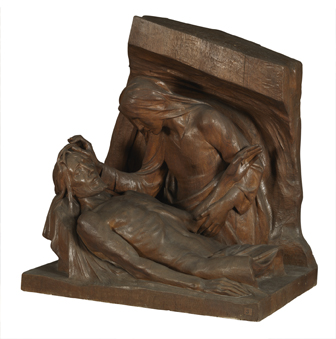

In [38]:
# Show a random image
def fixPath(path):
    return path.replace(".././", "../")

def getImagePath(image_path):
    return fixPath(os.path.join(IMAGES_FOLDER, image_path[1:]))

def loadImage(recordID):
    image_path = artpieces[artpieces["recordID"] == recordID]["imageLowResFilename"].values[0]
    return Image.open(getImagePath(image_path))

loadImage(random_recordID)


2256


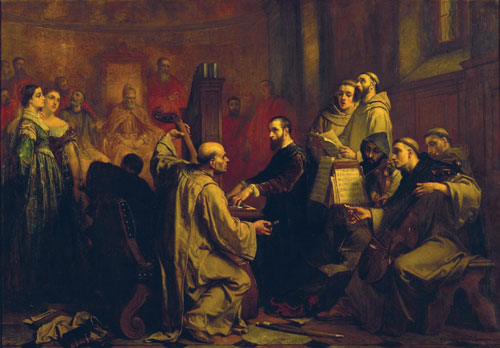

In [39]:
# Get recordID where imageLowresFilename contains "deChampaigne"
for index, row in artpieces.iterrows():
    img = row["imageLowResFilename"]
    if "HAMMAN-1320-L.jpg" in img:
        recordID = row["recordID"]
        print(recordID)
        break

loadImage(recordID)

In [27]:
device, dtype = detect_device()

model_id = "vikhyatk/moondream2"
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=LATEST_REVISION)
moondream = Moondream.from_pretrained(
    model_id,
    revision=LATEST_REVISION,
    torch_dtype=dtype,
).to(device=device)
moondream.eval()

image1 = Image.open("assets/demo-1.jpg")
image2 = Image.open("assets/demo-2.jpg")
prompts = [
    "What is the girl doing?",
    "What color is the girl's hair?",
    "What is this?",
    "What is behind the stand?",
]

answers = moondream.batch_answer(
    images=[image1, image1, image2, image2],
    prompts=prompts,
    tokenizer=tokenizer,
)

for question, answer in zip(prompts, answers):
    print(f"Q: {question}")
    print(f"A: {answer}")
    print()

In [48]:
moondream_captions = pd.DataFrame(columns=["recordID", "caption_EN", "caption_FR", "caption_NL"])
# Load existing captions
if os.path.exists(OUTPUT_MOONDREAM_CAPTIONS):
    moondream_captions = pd.read_csv(OUTPUT_MOONDREAM_CAPTIONS)
moondream_captions

,recordID,caption_EN,caption_FR,caption_NL


In [49]:
def generate_moondream_captions(recordID):
    image = loadImage(recordID)
    caption_EN = model.caption(image, length="short")["caption"]
    return caption_EN

In [50]:
for iteration, recordID in tqdm(enumerate(artpieces["recordID"])):
    if recordID in moondream_captions["recordID"].values:
        continue
    caption_EN = generate_moondream_captions(recordID)
    moondream_captions.loc[len(moondream_captions)] = [recordID, caption_EN, "", ""]

    if iteration % 20 == 0:
        moondream_captions.to_csv(OUTPUT_MOONDREAM_CAPTIONS, index=False)
        moondream_captions

moondream_captions.to_csv(OUTPUT_MOONDREAM_CAPTIONS, index=False)
moondream_captions


55it [01:11,  1.30s/it]


KeyboardInterrupt: 